# Machine Learning for the Sensored Internet of Things

<img src="ml-prediction.jpg">

## Who am I
Hank Roark
Data Scientist & Hacker @ H2O.ai

Lecturer in Systems Thinking, University of Illinois at Urbana-Champaign

John Deere, Research, Software Product Development, High Tech Ventures

Lots of time dealing with data off of machines, equipment, satellites, radar, hand sampled, and on.

Geospatial and temporal / time series data almost all from sensors.

Previously at startups and consulting (Red Sky Interactive, Nuforia, NetExplorer, Perot Systems, a few of my own)

Systems Design & Management MIT<br>
Physics Georgia Tech

hank@h2oai.com<br>
@hankroark<br>
https://www.linkedin.com/in/hankroark

## IoT Data Comes From Lots of Places, much of it from sensors

<img src="https://gkapteina.files.wordpress.com/2015/08/br-internet-of-things-ecosystem.jpg">

## The data is going to be huge, so get ready
<img src="http://www8.hp.com/h30458/media2.php/EZINE/April%20infographics/APR_IM_INFOG.jpg?version=349e115e815fac03bd19756911efee13">

## Wow, how big is a brontobyte?
<img src="http://www.intellaegis.com/wp-content/uploads/2015/01/IOT-Explosion.jpg">

# This much data will require a fast OODA loop
## Much of these models will then be used in control systems
<img src="http://www.telecom-cloud.net/wp-content/uploads/2015/05/Screen-Shot-2015-05-27-at-3.51.47-PM.png">

# Use Case on Simulated Sensor Data


## Prognostics
Prognostics is an engineering discipline focused on predicting the time at which a system or a component will no longer perform its intended function.  This lack of performance is most often a failure beyond which the system can no longer be used to meet desired performance. The predicted time then becomes the remaining useful life (RUL), which is an important concept in decision making for contingency mitigation.

https://en.wikipedia.org/wiki/Prognostics


## Machine Learning Prognostics for Turbofan Engine Degradation Dataset

Information about the problem is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan and original data is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

The data was originally generated using the Commercial Modular Aero-Propulsion System Simulations (C-MAPPS) system.

The approach used in the turbofan engine degradation dataset was then used in the PHM08 challenge.  Information about other research on the C-MAPSS data is available at  https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/phmc_14_063.pdf


## Sometimes the simple things work
"A significant characteristic of the PHM Challenge dataset is that it contains time series and therefore the representation of time or at least how to represent and take account of previous temporal observations is an important consideration. The <b>quickest and
simplest method for representing time is to consider each time
point independently and create a prediction at each time step</b>.
An alternative representation would be to consider using a
phase space embedding representation, in which a sequence of
instances is generated using a fixed length sliding window.
However <b>phase space embedding has the significant drawback
of increasing the number of dimensions proportionally with
each time step represented, giving rise to the problems
associated with the 'curse of dimensionality'</b>. From preliminary
experiments it was found that the prediction performance did
not improve significantly using the embedding space
representation given the increase in computational demands.
Therefore the chosen representation was to predict remaining
life using single time points".

Leto Peel, Member, IEEE (GOLD) " Data Driven Prognostics using a
Kalman Filter Ensemble of Neural Network Models" 2008
international conference on prognostics and health management.

## The approach of treating each time point independently will be used

In [1]:
# some ML
import h2o

# some munging, pre- and post-processing
import numpy as np
import pandas as pd
import pykalman as pyk

# some exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Doing hyper parameter searches only when needed
doGridSearch = False

# Preprocessing

In [2]:
# Input files don't have column names
dependent_vars = ['RemainingUsefulLife']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And we are going to add these columns
kalman_smoothed_mean_columns_names =["SensorMeasureKalmanMean"+str(i) for i in range(1,22)]

### Read in the raw files

In [3]:
train = pd.read_csv("train_FD001.txt", sep=r"\s*", header=None,
                   names=input_file_column_names, engine='python')
test  = pd.read_csv("test_FD001.txt",  sep=r"\s*", header=None,
                   names=input_file_column_names, engine='python')
test_rul = pd.read_csv("RUL_FD001.txt", header=None, names=['RemainingUsefulLife'])
test_rul.index += 1  # set the index to be the unit number in the test data set, 1 offset
test_rul.index.name = "UnitNumber"

### Calculate Remaining Useful Life in T-minus notation for the training data
This puts all data on the same basis for supervised training

In [4]:
# Calculate the remaining useful life for each training sample based on last measurement being zero remaining
grouped_train = train.groupby('UnitNumber', as_index=False)
useful_life_train = grouped_train.agg({'Cycle' : np.max })
useful_life_train.rename(columns={'Cycle': 'UsefulLife'}, inplace=True)
train_wfeatures = pd.merge(train, useful_life_train, on="UnitNumber")
train_wfeatures["RemainingUsefulLife"] = -(train_wfeatures.UsefulLife - train_wfeatures.Cycle)
train_wfeatures.drop('UsefulLife', axis=1, inplace=True)

## Exploratory Data Analysis

Look at how the sensor measures evolve over time (first column) as well as how they relate to each other for a subset of the units.


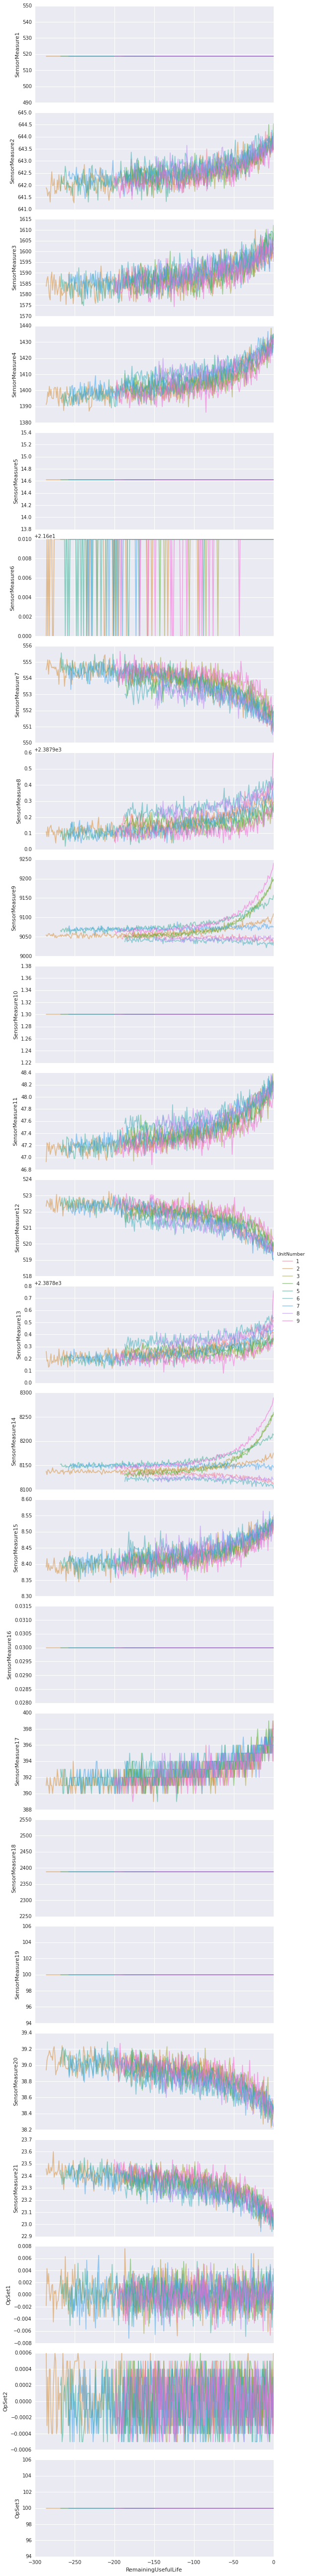

In [5]:
g = sns.PairGrid(data=train_wfeatures.query('UnitNumber < 10') ,
                 x_vars=dependent_vars,
                 y_vars=sensor_measure_columns_names + operational_settings_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.add_legend()

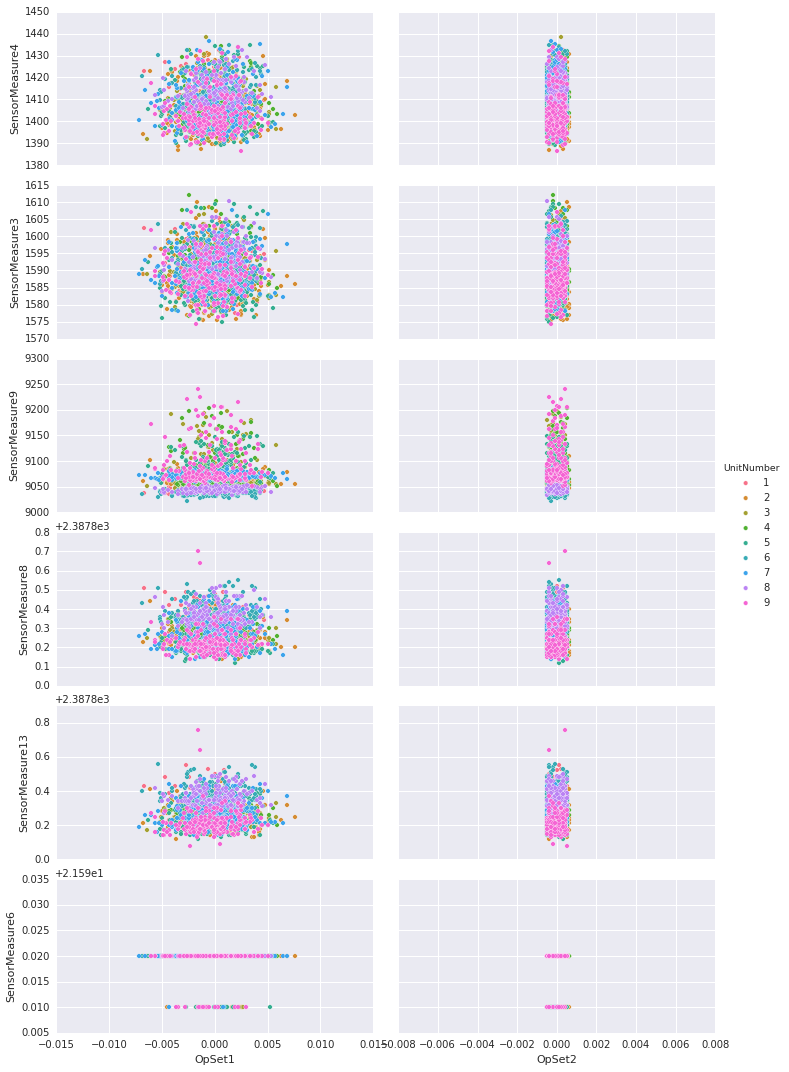

In [6]:
g = sns.pairplot(data=train_wfeatures.query('UnitNumber < 10'),
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", "SensorMeasure9", "SensorMeasure8", "SensorMeasure13", "SensorMeasure6"],
                 hue="UnitNumber", aspect=2)


## Feature Selection

These features were selected partially after looking at the graphs above...

But partially because later on thin the ML work certain features produced more predictive models (e.g., including Sensor 6 improved cross validation results) and some things improve results (Operational Settings).

In [8]:
sensor_numbers_to_keep = [2,3,4,6,7,8,9,11,12,13,14,15,17,20,21]
kept_sensor_measure_columns_names = ["SensorMeasure"+str(i) for i in sensor_numbers_to_keep]
kalman_smoothed_mean_columns_names = ["SensorMeasureKalmanMean"+str(i) for i in sensor_numbers_to_keep]

features_to_drop=["SensorMeasure1", "SensorMeasure5", "SensorMeasure19",  
                  "SensorMeasure10","SensorMeasure16","SensorMeasure18", 
                  ]  # TODO, generate as set difference

train_w_selected_features = train_wfeatures.drop(features_to_drop, axis=1)
test_w_selected_features  = test.drop(features_to_drop, axis=1)

### Signal processing using Kalman smoothing filter
Kalman filters use the prior belief about the state of a system, and ensembles measurement of the next measured state and model of how the system evolves from prior state (physics!) to make an improved estimate of the current system state.  In the absense of having the 'physics' and knowledge about the sensors, here we estimate the parameters for the Kalman filter.  Kalman filters are like smoothers, but  use future state information in addition to prior state information.

A visual introduction to Kalman filters is available at http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ .  A great hackers introduction to Kalman and Bayseian filters is at  https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python .

<img src="cycle.png">

The hypothesis is that the state of the systems under consideration evolves in this time series manner and that the sensors are noisy.  Kalman parameters were determined using EM algorithm and then those parameters are used for smoothing the signal data.  This is applied repeatedly to each Unit, in both the training and test set.

Again, deciding to do 'smoothing' was based on feedback from the models that are later in the notebook as well as a belief in the dynamics of the system under consideration.  Models using Kalman smoothing produced better predictive performance than using raw data ( marginally better, so need to decide if complexity / computation is beneficial).  Other smoothers could be considered but were not.  

H2O now has Discrete Cosine Transforms (DCT) so those can be applied to data at scale in a distributed, in memory environment:  https://0xdata.atlassian.net/browse/PUBDEV-1865.  Also, see SciPy's signal and interpolation packages.

(image courtesy of http://www.codeproject.com/Articles/865935/Object-Tracking-Kalman-Filter-with-Ease)

In [9]:
kalman_smoothed_mean_columns_names = ["SensorMeasureKalmanMean"+str(i) for i in sensor_numbers_to_keep]

In [10]:

def calcSmooth(measures):
    kf = pyk.KalmanFilter(initial_state_mean=measures[0], n_dim_obs=measures.shape[1])
    (smoothed_state_means, smoothed_state_covariances) = kf.em(measures).smooth(measures)
    return smoothed_state_means

def filterEachUnit(df):
    dfout = df.copy()
    
    for newcol in kalman_smoothed_mean_columns_names:
        dfout[newcol] = np.nan
    
    for unit in dfout.UnitNumber.unique():
        print 'Processing Unit: ' + str(unit)
        unitmeasures = dfout[dfout.UnitNumber == unit][kept_sensor_measure_columns_names]
        smoothed_state_means = calcSmooth( np.asarray( unitmeasures ) )
        dfout.loc[dfout.UnitNumber == unit, kalman_smoothed_mean_columns_names] = smoothed_state_means
        print 'Finished   Unit: ' + str(unit)
        
    return dfout

train_wkalman=filterEachUnit(train_w_selected_features)
test_wkalman=filterEachUnit(test_w_selected_features)

Processing Unit: 1
Finished   Unit: 1
Processing Unit: 2
Finished   Unit: 2
Processing Unit: 3
Finished   Unit: 3
Processing Unit: 4
Finished   Unit: 4
Processing Unit: 5
Finished   Unit: 5
Processing Unit: 6
Finished   Unit: 6
Processing Unit: 7
Finished   Unit: 7
Processing Unit: 8
Finished   Unit: 8
Processing Unit: 9
Finished   Unit: 9
Processing Unit: 10
Finished   Unit: 10
Processing Unit: 11
Finished   Unit: 11
Processing Unit: 12
Finished   Unit: 12
Processing Unit: 13
Finished   Unit: 13
Processing Unit: 14
Finished   Unit: 14
Processing Unit: 15
Finished   Unit: 15
Processing Unit: 16
Finished   Unit: 16
Processing Unit: 17
Finished   Unit: 17
Processing Unit: 18
Finished   Unit: 18
Processing Unit: 19
Finished   Unit: 19
Processing Unit: 20
Finished   Unit: 20
Processing Unit: 21
Finished   Unit: 21
Processing Unit: 22
Finished   Unit: 22
Processing Unit: 23
Finished   Unit: 23
Processing Unit: 24
Finished   Unit: 24
Processing Unit: 25
Finished   Unit: 25
Processing Unit: 2

## Exploratory analysis of the difference between the 'raw' sensor data and the smoothed data

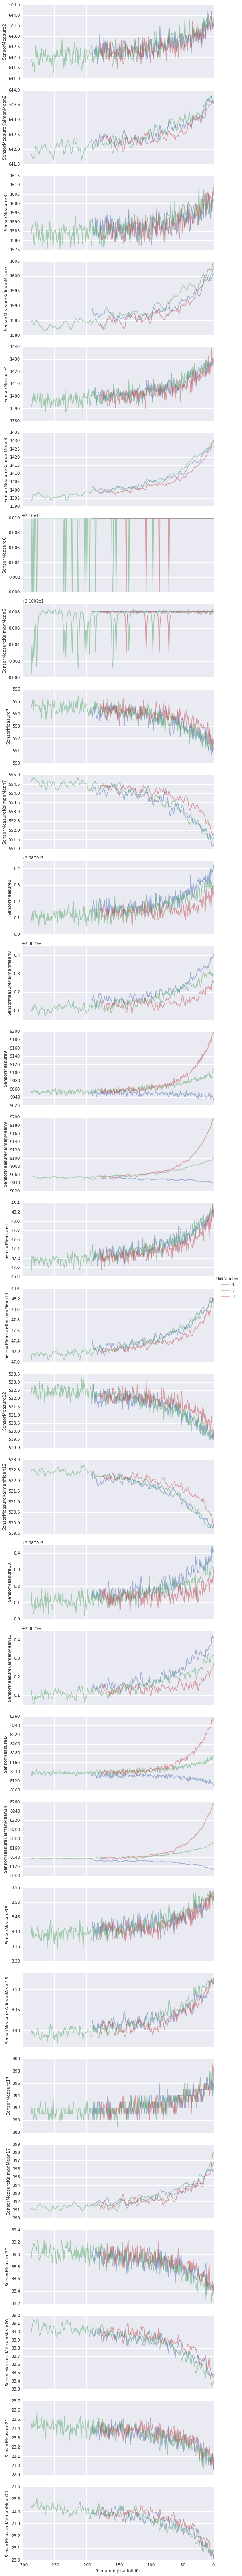

In [11]:
g = sns.PairGrid(data=train_wkalman.query('UnitNumber < 4') ,
                 x_vars=dependent_vars,
                 y_vars=[val for pair in zip(kept_sensor_measure_columns_names,kalman_smoothed_mean_columns_names) for val in pair],
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.add_legend()

### Output the results to files
Helps so preprocessing only has to be done once.

In [12]:
# Get picky about the order of output columns
test_output_cols = index_columns_names + kept_sensor_measure_columns_names +kalman_smoothed_mean_columns_names
train_output_cols = test_output_cols + dependent_vars

train_output = train_wkalman[train_output_cols]
test_output = test_wkalman[test_output_cols]

In [13]:
# Output the files, so we don't have to do the preprocessing again.
train_output.to_csv("train_FD001_preprocessed.csv", index=False)
test_output.to_csv("test_FD001_preprocessed.csv", index=False)
test_rul.to_csv("rul_FD001_preprocessed.csv", index=True)

# Modeling

### Startup H2O

In [14]:
h2o.init()

H2O cluster uptime:,15 minutes 10 seconds 931 milliseconds
H2O cluster version:,3.3.0.3176
H2O cluster name:,H2ODemo
H2O cluster total nodes:,1
H2O cluster total memory:,192.19 GB
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


### Load training and final test data into H2O

In [15]:
train_hex = h2o.import_file("/home/ec2-user/python-examples/cmapdata/train_FD001_preprocessed.csv")
test_hex = h2o.import_file("/home/ec2-user/python-examples/cmapdata/test_FD001_preprocessed.csv")


Parse Progress: [##################################################] 100%
Imported /home/ec2-user/python-examples/cmapdata/train_FD001_preprocessed.csv. Parsed 20,631 rows and 33 cols

Parse Progress: [##################################################] 100%
Imported /home/ec2-user/python-examples/cmapdata/test_FD001_preprocessed.csv. Parsed 13,096 rows and 32 cols


### Setup independent and dependent features

Use the operational settings and Kalman smoothed mean states as the independent features

Setup a fold column to great cross validation models from 90 units and cross validating on 10 units.  This creates a 10-fold cross validation.  The cross validation models are then used to create an ensemble model for predictions

In [16]:
x_cols = kalman_smoothed_mean_columns_names
y_col = dependent_vars

fold_col = "UnitNumberMod10"
train_hex[fold_col] = train_hex["UnitNumber"] % 10

### Train a series of GLM Models using Grid Search over $\alpha$ and $\lambda$
I like GLMs, they are fast.  But don't deal well with non-linearity.

TODO: Consider some addition feature engineering / transforms (log transforms)

In [18]:
def train_glm(x_cols, y_col, training_frame, fold_col, alpha=0.5, penalty=1e-5):
    return h2o.glm(x=x_cols, y=y_col, training_frame=training_frame, 
                   fold_column=fold_col,family = "gaussian",
                   alpha = [alpha], Lambda = [penalty],
                   keep_cross_validation_predictions=True )

def grid_search_glm(x_cols, y_col, training_frame, fold_col, alphas = [0,0.5,1], penalties=np.logspace(-3,0,num=4)):
    results = []
    for alpha in alphas:
        for penalty in penalties:
            results.append( train_glm(x_cols, y_col, training_frame=training_frame, 
                                      fold_col=fold_col, alpha=alpha, penalty=penalty) )
    return results

if doGridSearch:
    glm_models = grid_search_glm(x_cols,y_col,training_frame=train_hex,fold_col=fold_col)
else:
    # this is used to speed up the demonstration by just building the single model previously found
    glm_models = glm_models(x_cols,y_col,train_hex,fold_col,alpha=0,penalty=0.01 )


glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [#####################################

### Extract the 'best' model

Uses model with lowest MSE on the cross validation data.  MSE is not the final scoring method, but was used as a reasonable substitute for the actual score.  This is a reasonable substitute for using the final scoring method, for now.

In [19]:
def extract_best_model(models):
    bestMse = models[0].mse(xval=True)
    result = models[0]
    for model in models:
        if model.mse(xval=True) < bestMse:
            bestMse = model.mse(xval=True)
            result = model
    return result

best_glm_model = extract_best_model(glm_models)
best_glm_model

Model Details
H2ORegressionModel :  Generalized Linear Model
Model Key:  GLM_model_python_1442419391050_4
       family      link           regularization  number_of_predictors_total  \
0    gaussian  identity  Ridge ( lambda = 0.01 )                          15   

   number_of_active_predictors  number_of_iterations  \
0                           16                     1   

                           training_frame  
0  pyf35e28c8-31c8-4cb4-8d5e-6aa86879c3be  


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1907.88535332
R^2: 0.597862510862
Mean Residual Deviance: 1907.88535332
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 39361582.7244
AIC: 214423.673745

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1976.78991168
R^2: 0.583339045896
Mean Residual Deviance: 1976.78991168
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.090

### Build a series of RF models using grid search for hyper-parameters

Extract the 'best' model using the same approach as with GLM.

In [20]:
def train_rf(x_cols, y_col, training_frame, fold_column, ntrees, max_depth):
    return h2o.random_forest(x=x_cols, y=y_col, training_frame=training_frame, keep_cross_validation_predictions=True,
                             fold_column=fold_column,ntrees=ntrees, max_depth=max_depth)

def grid_search_rf(x_cols, y_col, training_frame, fold_column, ntrees=[100,300], max_depth=[5,10,15]):
    results = []
    for ntree in ntrees:
        for depth in max_depth:
            print "RF: {ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"}"
            results.append( train_rf(x_cols, y_col, training_frame, fold_column, ntrees=ntree, max_depth=depth) )
    return results

def train_gbm(x_cols, y_col, training_frame, fold_column, ntrees, max_depth, learn_rate):
    return h2o.gbm(x=x_cols, y=y_col, training_frame=training_frame, learn_rate=learn_rate,
                   keep_cross_validation_predictions=True,
                   fold_column=fold_column,ntrees=ntrees, max_depth=max_depth)

def grid_search_gbm(x_cols, y_col, training_frame, fold_column, ntrees=[100,300,1000], max_depth=[1,3,5], learn_rate=[0.1,0.03]):
    results = []
    for ntree in ntrees:
        for depth in max_depth:
            for rate in learn_rate:
                print "GBM: {ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"},{"+str(rate)+"}"
                results.append( train_gbm(x_cols, y_col, training_frame, fold_column, ntrees=ntree, max_depth=depth, learn_rate=rate) )
    return results



## Start with RF, tends to be easy to tune and deals with noise well

In [22]:
if doGridSearch:
    rf_models = grid_search_rf(x_cols, y_col, train_hex, fold_col, \
                               ntrees=[100,300], max_depth=[5,10,15])
else:
    rf_models = [train_rf(x_cols, y_col, train_hex, fold_col, ntrees=300, max_depth=5)]

RF: {ntrees: 100},{max_depth: 5}

drf Model Build Progress: [##################################################] 100%
RF: {ntrees: 100},{max_depth: 10}

drf Model Build Progress: [##################################################] 100%
RF: {ntrees: 100},{max_depth: 15}

drf Model Build Progress: [##################################################] 100%
RF: {ntrees: 300},{max_depth: 5}

drf Model Build Progress: [##################################################] 100%
RF: {ntrees: 300},{max_depth: 10}

drf Model Build Progress: [##################################################] 100%
RF: {ntrees: 300},{max_depth: 15}

drf Model Build Progress: [##################################################] 100%


## Now GBM.  I really like GBMs.  
Sometimes can memorize noise, so be careful of overfitting.

GBMs have lots of parameters, so computation can take time.  I tend to fix the number of trees and tune the other parameters around it.  For time, I settled on 300, but 1000 is my normal amount.

Don't be afraid of deep interactions with GBMs.  Common recommendation is to be shrubs (shallow trees), but I find that deep trees often work.

In [25]:
do_gbm_grid_search = True
if doGridSearch and do_gbm_grid_search:
    gbm_models = grid_search_gbm(x_cols, y_col, train_hex, fold_col, 
                                 ntrees=[300], max_depth=[5,7,10], learn_rate=[0.01,0.02,0.005])
else:
    gbm_models = [train_gbm(x_cols, y_col, train_hex, fold_col,ntrees=300, max_depth=5, learn_rate=0.01)]

GBM: {ntrees: 300},{max_depth: 5},{0.01}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 5},{0.02}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 5},{0.005}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 7},{0.01}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 7},{0.02}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 7},{0.005}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 10},{0.01}

gbm Model Build Progress: [##################################################] 100%
GBM: {ntrees: 300},{max_depth: 10},{0.02}

gbm Model Build Progress: [#############################################

## Deep Learning

Lots of opportunity here.  Lots of reports of multi-layer feed forward neural network doing well.  See http://www.ijens.org/103706-5252%20IJET-IJENS.pdf for an example. 

## Model Selection

MSE of RF model on validation:  1732 vs GLM 1974

Interaction Depth 10, 300 trees

Looks like more trees might even improve things (something TODO later); nice thing about RF is that it tends not to overfit so adding more trees is just a matter of allocating the computing time.

In [23]:
best_rf_model = extract_best_model(rf_models)
best_rf_model

Model Details
H2ORegressionModel :  Distributed RF
Model Key:  DRF_model_python_1442419391050_34
     number_of_trees  model_size_in_bytes  min_depth  max_depth  mean_depth  \
0                300              2951041         10         10          10   

   min_leaves  max_leaves  mean_leaves  
0         780         900    847.07666  


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1241.28973157
R^2: 0.738365235062
Mean Residual Deviance: 1241.28973157

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 1732.8905585
R^2: 0.634747309668
Mean Residual Deviance: 1732.8905585
                 timestamp           duration  number_of_trees  training_MSE  \
0      2015-09-16 16:30:42   3 min  3.523 sec                1   1544.379401   
1      2015-09-16 16:30:42   3 min  3.576 sec                2   1482.820342   
2      2015-09-16 16:30:42   3 min  3.627 sec                3   1464.258011   
3      2015-09-16 16:30:42   3 min  3.680 sec             

Best GBM model has MSE of 1688 on xvals, beating other models.

Params of selected model: 300 trees, depth 5, learning rate 0.01

In [26]:
best_gbm_model = extract_best_model(gbm_models)
best_gbm_model

Model Details
H2ORegressionModel :  Gradient Boosting Machine
Model Key:  GBM_model_python_1442419391050_38
     number_of_trees  model_size_in_bytes  min_depth  max_depth  mean_depth  \
0                300               127586          5          5           5   

   min_leaves  max_leaves  mean_leaves  
0          27          32    31.123333  


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1264.80813351
R^2: 0.733408107481
Mean Residual Deviance: 1264.80813351

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1688.53981645
R^2: 0.644095405986
Mean Residual Deviance: 1688.53981645
                 timestamp           duration  number_of_trees  training_MSE  \
0      2015-09-16 16:43:06   3 min  6.202 sec                1   4682.171706   
1      2015-09-16 16:43:06   3 min  6.246 sec                2   4621.187364   
2      2015-09-16 16:43:06   3 min  6.290 sec                3   4561.445414   
3      2015-09-16 16:43:06   3 min  6.333 sec

# Best model is GBM with depth 5, learning rate 0.01, and 300 trees

In [ ]:
best_gbm_model.params

Best GBM Model reported MSE on cross validation data as 1688, vs RF 1732 vs GLM 1974.

### Exploratory model analysis

See how well the models do predicting on the training set.  Should be pretty good, but often worth a check.  

Predictions are an ensemble of the 10-fold cross validation models and the original model.

These can get a lot smarter, like super learners.  See H2OEnsemble package.

In [28]:
def make_ensemble_predictions(m,frame):
    # train_hex["weights"] = 1
    allModels = m.xvals + [m]
    pred = sum([model.predict(frame) for model in allModels]) / len(allModels)
    return pred 

In [29]:
pred = make_ensemble_predictions(best_gbm_model,train_hex)
pred["actual"] = train_hex["RemainingUsefulLife"]
pred["unit"] = train_hex["UnitNumber"]

### Plot actual remaining useful life vs predicted remaining useful life

Ideally all points would be on the diagonal, indication prediction from data matched exactly the actual.

Also, it is important that the prediction gets more accurate the closer it gets to no useful life remaining.

Looking at a sample of the first 12 units.

Moved predictions from H2O to Python Pandas for plotting using Seaborn.

In [30]:
scored_df = pred.as_data_frame(use_pandas=True)

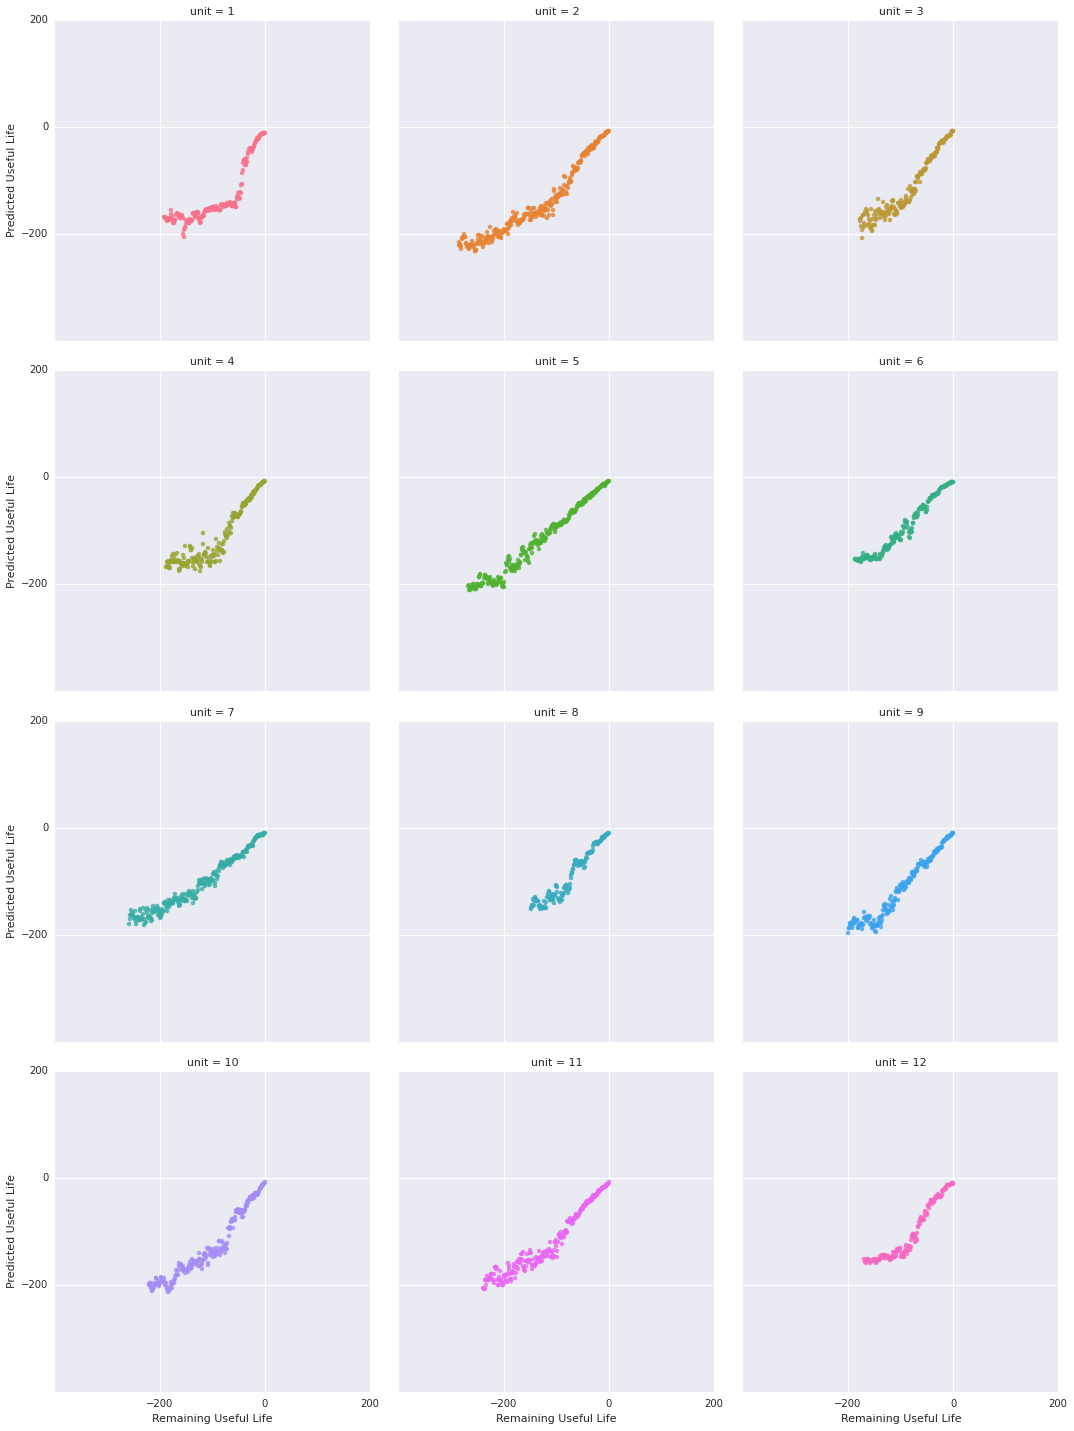

In [31]:
g=sns.lmplot(x="actual",y="predict",hue="unit",col="unit",data=scored_df[scored_df.unit < 13],col_wrap=3,fit_reg=False)

g = (g.set_axis_labels("Remaining Useful Life", "Predicted Useful Life")
      .set(xlim=(-400, 200), ylim=(-400, 200),
           xticks=[-200, 0, 200], yticks=[-200, 0, 200]))

# Model prediction and assessment

### Predict on the hold-out test set, using an average of all the cross validation models.

In [32]:
testPreds = make_ensemble_predictions(best_gbm_model, test_hex)

Append the original index information (Cycle and UnitNumber) to the predicted values so we have them later.

In [33]:
testPreds["Cycle"] = test_hex["Cycle"]
testPreds["UnitNumber"] = test_hex["UnitNumber"]

Move the predictions over to Python Pandas for final analysis and scoring

In [34]:
testPreds_df = testPreds.as_data_frame(use_pandas=True)

Load up the actual Remaining Useful Life information.

In [35]:
actual_RUL = pd.read_csv("/home/ec2-user/python-examples/cmapdata/rul_FD001_preprocessed.csv")

The final scoring used in the competition is based on a single value per unit.  We extract the last prediction for use in final scoring.  Other methods could be used, but would need to be included in the cross validation process.

In [50]:
def aggfunc(x):
    return np.mean( x.order().tail(1) )

grouped_by_unit_preds = testPreds_df.groupby("UnitNumber", as_index=False)
predictedRUL = grouped_by_unit_preds.agg({'predict' : aggfunc })
predictedRUL.predict = -predictedRUL.predict

Add the prediction to the actual data frame, and use the scoring used in the PHMO8 competition (more penality for predicting more useful life than there is actual).

In [51]:
final = pd.concat([actual_RUL, predictedRUL.predict], axis=1)

In [52]:
def rowScore(row):
    d = row.predict-row.RemainingUsefulLife
    return np.exp( -d/10 )-1 if d < 0 else np.exp(d/13)-1

rowScores = final.apply(rowScore, axis=1)

# This is the final score using PHM08 method of scoring.

This would have been a top 10 score: between 6th and 7th place.

Sensor 6 moved this up from being between 18th and 19th place.

I completed this analysis is about 2 days of part-time work.   Economics would need to dictate if it needs to be improved.

I'd expect this score to improve with more data.  This was a small dataset, so more observations would likely help the learning.

In [53]:
sum(rowScores)

1044.1420418080802

### Finally look at the actual remaining useful life and compare to predicted

Some things that should ideally would be true:
- As RUL gets closer to zero, the prediction gets closer to actual

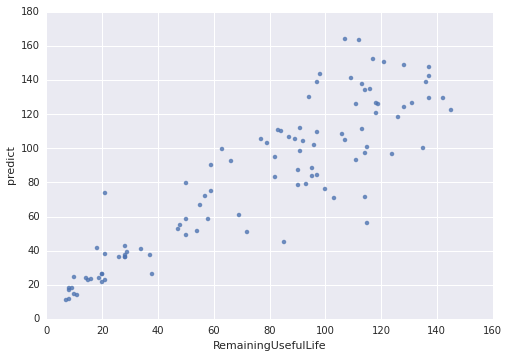

In [54]:
sns.regplot("RemainingUsefulLife", "predict", data=final, fit_reg=False);


## Quick comparison to best GLM model

TODO: repeated code, clean up

In [55]:
test_preds_glm = make_ensemble_predictions(best_glm_model, test_hex)

In [56]:
test_preds_glm["Cycle"] = test_hex["Cycle"]
test_preds_glm["UnitNumber"] = test_hex["UnitNumber"]
test_preds_glm_df = test_preds_glm.as_data_frame(use_pandas=True)

In [57]:
grouped_by_unit_preds_glm = test_preds_glm_df.groupby("UnitNumber", as_index=False)
predicted_rul_glm = grouped_by_unit_preds_glm.agg({'predict' : aggfunc })
predicted_rul_glm.predict = -predicted_rul_glm.predict
final_glm = pd.concat([actual_RUL, predicted_rul_glm.predict], axis=1)
row_scores_glm = final_glm.apply(rowScore, axis=1)
sum(row_scores_glm)

2281.0457371359107

Another top 20 finish, between 18th and 19th place.

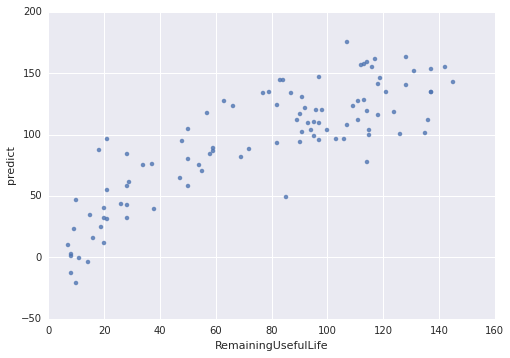

In [58]:
sns.regplot("RemainingUsefulLife", "predict", data=final_glm, fit_reg=False);

# Key take aways

## Some sort of signal processing is usually helpful, but can introduce bias

### - Smoothers, filters, frequency domain, interpolation, LOWESS, ... , feature engineering

## Validation strategy is important

### - Easy to memorize due to autocorrelation

## Sometimes the simplest things work

### - Treat each observation independently; Use time, location, as data elements

## Uncertainty is the name of the game

### - Methods that will report out probabilities are often required (not shown here)

## The data can be big, get ready, it'll be a great ride

<img src="h2oworldpostcardfrontwithurl.png">
<center></center>

<hr>
hank@h2oai.com<br>
@hankroark<br>
https://www.linkedin.com/in/hankroark